# Quantum Control as Polynomial Optimization: Piecewise constant controls 

This notebook uses multithreadin. Set  

    export JULIA_NUM_THREADS=100
   
before runing Julia

In [1]:
Threads.nthreads()

110

In [2]:
using LinearAlgebra
using DynamicPolynomials
using TSSOS
using QuadGK
using JuMP
using Random
using NLopt
using SpecialFunctions
using HDF5

## Quantum system

In [3]:
#= 
Quantum system is taken from 
 https://github.com/q-optimize/c3/blob/master/examples/two_qubits.ipynb

Drift Hamiltonian
=#

H0 = [
    0 0 0;
    0 3.21505101e+10 0;
    0 0 6.23173079e+10
];

H0 ./= norm(H0, Inf)

# Control Hamiltonian
V = [
    0 1 0;
    1 0 1.41421356;
    0 1.41421356 0
]

V ./= norm(V, Inf);

## Chebyshve polynomial approximation for $\exp_p(\Delta t \Omega)$

In [4]:
"""
Chebyshev approximation for exp(Δt Ω)
"""
function exp_chebyshev(Δt::Real, Ω::AbstractMatrix, order::Integer)
    
    Tₙ₋₁ = I
    Tₙ  = Ω
    
    # The first two terms of Chebyshev series for exp
    series = besselj(0, Δt) * Tₙ₋₁ + 2 * besselj(1, Δt) * Tₙ
    
    for n=2:order
        Tₙ₊₁  = 2 * Ω * Tₙ + Tₙ₋₁
        
        series .+= 2 * besselj(n, Δt) * Tₙ₊₁
        
        (Tₙ, Tₙ₋₁) = (Tₙ₊₁, Tₙ) 
    end
    
    series
end

exp_chebyshev

In [5]:
@polyvar x[1:2]

# final time
const T = 0.5

Δt = T / size(x)[1]

𝓤 = prod(exp_chebyshev(Δt, -im * (H0 + ξ * V), 7) for ξ in x);

## Utilities

In [6]:
function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))# if ~isapproxzero(abs(c))
    )
end

function square_frobenius_norm(M::AbstractArray)
    #=
    Square of the Frobenius norm of a matrix
    =#
    real_poly(sum(z' * z for z in M))
end

function propagate(x::AbstractArray)   
    #=
    Solve the equation of motion
    =#
    prod(exp(-im * Δt * (H0 + ξ * V)) for ξ in x)
end

function 𝓤_propagation(x::AbstractArray)   
    map(z -> z(x), 𝓤)
end

𝓤_propagation (generic function with 1 method)

## Read target unitiries

In [7]:
h5open("results.hdf5", "r") do fid
    global U_targets = read(fid["U_targets"])
    global magnus_norm_U_target_minus_obtained = read(fid["norm_U_target_minus_obtained"])
end;

In [8]:
@time begin
    
n_samples = size(U_targets)[1]
    
# Frobenius norm difference between target and obtained unitaries
norm_U_target_minus_obtained = zeros(n_samples)

# Difference between symbolic exponent and exact to check accuracy  
norm_𝓤_propagation_exact = zeros(n_samples)
    
Threads.@threads for i=1:n_samples
    
    # target unitray
    U_target = U_targets[i, :, :]
        
    # get the polynomial objective function
    obj = square_frobenius_norm(
        U_target - 𝓤
    )
    
    # Get the global minimum via TSSOS library
    opt,sol,data = tssos_first(obj, variables(obj); QUIET = true, solution = true)
    
    previous_sol = sol
    previous_opt = opt
    
    while ~isnothing(sol)
        previous_sol = sol
        previous_opt = opt
            
        opt,sol,data = tssos_higher!(data; QUIET = true, solution = true)
    end

    min_x = previous_sol

    # Frobenius norm difference between target and obtained unitaries
    U_obtained = propagate(min_x)
    norm_U_target_minus_obtained[i] = norm(U_target - U_obtained)
        
    # Difference between symbolic exponent and exact to check accuracy 
    norm_𝓤_propagation_exact[i] = norm(U_obtained - 𝓤_propagation(min_x))   
end
    
end

************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************

Global optimality certified!
No higher TSSOS hierarchy!
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 1.5987064362069517e-8
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
Global optimality certified!
No higher TSSOS hierarchy!
Global optimality certified!
No higher TSSOS hierarchy!
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 1.0646377931830704e-7
Global optimality certified!
No higher TSSOS hierarchy!
Global optimality certified!
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************T

optimum = 1.0837864413789004e-7
Global optimality certified!
optimum = 7.717269704003455e-8
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
optimum = 2.264142753449369e-7
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
optimum = 9.576208681219583e-9
Global optimality certified!
optimum = 1.4213699925676036e-8
Global optimality certified!
optimum = 1.2597846604958285e-8
optimum = 1.0763644271736594e-7
optimum = 5.87217842507763e-8
optimum = 1.6382152401299946e-7
optimum = 9.676550211957973e-9
optimum = 1.3581812840802876e-8
optimum = 8.5004

optimum = 1.0266321025346796e-8
Global optimality certified!
Global optimality certified!
optimum = 4.829530018629065e-8
optimum = 7.50818996974416e-9
optimum = 1.619822013319213e-8
Global optimality certified!
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 2.8586549907659352e-8
No higher TSSOS hierarchy!
Global optimality certified!
Global optimality certified!
optimum = 8.31316291152421e-9
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 9.919064620198875e-9
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
optimum = 1.2888305991412474e-7
opti

optimum = 4.931749270546357e-8
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
optimum = 1.52820285804224e-8
optimum = 1.0416677900356166e-8
optimum = 9.71812142978947e-9
No higher TSSOS hierarchy!
optimum = 8.228350209912162e-9
No higher TSSOS hierarchy!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
optimum = 4.477115317858998e-8
No higher TSSOS hierarchy!
optimum = 1.0161541726500312e-8
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
optimum = 7.477589864800828e-8
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS***

optimum = 3.8111302135884195e-8
optimum = 8.623424530925267e-8
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
optimum = 7.737868502545249e-9
Global optimality certified!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 1.1188062321288081e-8
No higher TSSOS hierarchy!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
optimum = 4.328507541962583e-8
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
Global optimality certified!
************************TS

optimum = 2.3409882702790616e-8
optimum = 1.7742593897022283e-7
No higher TSSOS hierarchy!
Global optimality certified!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 1.392149323974815e-7
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 8.772005246882062e-8
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 9.658581914499609e-9
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
No higher TSSOS hierarchy!
Global optimality certified!
optimum = 1.7489723321756007e-8

optimum = 1.2879607597989236e-7
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
Global optimality certified!
No higher TSSOS hierarchy!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
optimum = 8.184171535693417e-9
No higher TSSOS hierarchy!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 8.963328557359754e-8
Global optimality certified!
optimum = 2.3418991270597619e-7
Global optimality certified!
optimum = 7.84484182425119e-8
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS*********************

optimum = 9.324101785788847e-9
optimum = 2.0995018455047605e-8
Global optimality certified!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 1.1107755411753967e-7
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 7.440984031980132e-8
No higher TSSOS hierarchy!
Global optimality certified!
optimum = 8.600000062911002e-9
Glob

optimum = 4.544050723663691e-8
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
optimum = 7.056297981498085e-8
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 2.0407796556014543e-8
Global optimality certified!
optimum = 5.414357334190802e-8
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
Global optimality certified!
optimum = 1.4515970466519024e-7
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
optimum = 1.663738381389664e-8
optimum = 1.4745526756450008e-8
optimum = 3.459383366050666e-8
optimum = 1.675019683331145e-8
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
optimum = 1.0283775941116295e-8
Global optimality certified!
Global optimality certified!
Global optimality ce

optimum = 9.412679233086025e-9
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 1.0539985664779461e-8
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
optimum = 2.227305719623658e-8
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 1.7521670091999296e-8
**********************

optimum = 1.0958957171840152e-8
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 1.9339983206226504e-8
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 7.351469010287259e-9
Global optimality certified!
optimum = 2.0126672319123657e-8
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
optimum = 8.693670222410027e-9
Global optimality certified!
optimum = 7.238453919689974e-9
optimum = 1.2414402096767132e-8
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 1.3533057653631783e-8
Global optimality certified!
No higher TSSOS hierarchy!


Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
optimum = 8.459654204329367e-9
No higher TSSOS hierarchy!
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 1.3098412719092014e-8
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 1.2000061476847884e-8
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
optimum = 1.2455800061345564e-7
N

optimum = 2.5961890111162846e-8
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
optimum = 2.7059297273594126e-7
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 9.949669432631003e-9
Global optimality certified!
optimum = 1.1904267173521865e-8
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 8.182000387860055e-8
Global optimality certified!
optimum = 1.50315982400784e-7
No higher TSSOS hierarchy!
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 7.352108653430973e-8
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 8.575171903322964e-9
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 4.769787312818542e-8
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
optimum = 9.193466811570058e-9
Globa

## Analysis

In [9]:
using Plots
using LaTeXStrings

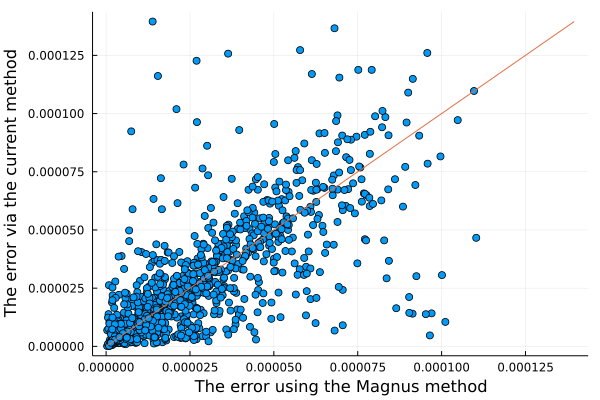

In [10]:
scatter(magnus_norm_U_target_minus_obtained, norm_U_target_minus_obtained, label=nothing)

lower = min(minimum(magnus_norm_U_target_minus_obtained), minimum(norm_U_target_minus_obtained))
higher = max(maximum(magnus_norm_U_target_minus_obtained), maximum(norm_U_target_minus_obtained))
plot!([lower, higher], [lower, higher], label=nothing)

xlabel!("The error using the Magnus method")
ylabel!("The error via the current method")